# Landing Congestion Analysis

Explore the impact of landing shock events on stochastic playback outputs for the synthetic medium scenario.

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd().resolve()
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / 'pyproject.toml').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'pyproject.toml').exists():
    raise RuntimeError('Notebook must be executed within a FHOPS checkout (pyproject.toml not found).')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from docs.examples.analytics import utils

from fhops.scenario.synthetic import SyntheticDatasetConfig, sampling_config_for

SCENARIO = PROJECT_ROOT / 'examples/synthetic/medium/scenario.yaml'
ASSIGNMENTS = PROJECT_ROOT / 'docs/examples/analytics/data/synthetic_medium_sa_assignments.csv'

config = SyntheticDatasetConfig(
    name='synthetic-medium',
    tier='medium',
    num_blocks=8,
    num_days=12,
    num_machines=4,
)

baseline_sampling = sampling_config_for(config).model_copy()
baseline_sampling.landing.enabled = False
baseline_tables, baseline_sampling = utils.run_stochastic_summary(
    SCENARIO, ASSIGNMENTS, sampling_config=baseline_sampling
)

shock_sampling = baseline_sampling.model_copy()
shock_sampling.landing.enabled = True
shock_sampling.landing.probability = 0.3
shock_sampling.landing.capacity_multiplier_range = (0.35, 0.7)
shock_sampling.landing.duration_days = 3
shock_tables, shock_sampling = utils.run_stochastic_summary(
    SCENARIO, ASSIGNMENTS, sampling_config=shock_sampling
)

## Baseline Ensemble Snapshot

In [2]:
baseline_tables.shift.head()

,day,shift_id,machine_id,machine_role,sample_id,production_units,total_hours,idle_hours,mobilisation_cost,sequencing_violations,blackout_conflicts,available_hours,utilisation_ratio,downtime_hours,downtime_events,weather_severity_total
0,2,S1,M4,forwarder,0,6.8682,10.024585,0.0,0.0,0,0,10.024585,1.0,0.0,0,0.4
1,8,S1,M1,harvester,0,13.8230,10.024585,0.0,0.0,0,0,10.024585,1.0,0.0,0,0.0
2,2,S1,M1,harvester,1,12.7850,10.024585,0.0,0.0,0,0,10.024585,1.0,0.0,0,0.0
3,8,S1,M1,harvester,1,8.2938,10.024585,0.0,0.0,0,0,10.024585,1.0,0.0,0,0.4
4,2,S1,M4,forwarder,2,11.4470,10.024585,0.0,0.0,0,0,10.024585,1.0,0.0,0,0.0


## Landing Shock Ensemble Snapshot

In [3]:
shock_tables.shift.head()

,day,shift_id,machine_id,machine_role,sample_id,production_units,total_hours,idle_hours,mobilisation_cost,sequencing_violations,blackout_conflicts,available_hours,utilisation_ratio,downtime_hours,downtime_events,weather_severity_total
0,2,S1,M4,forwarder,0,6.868200,10.024585,0.0,0.0,0,0,10.024585,1.0,0.0,0,0.4
1,8,S1,M1,harvester,0,13.823000,10.024585,0.0,0.0,0,0,10.024585,1.0,0.0,0,0.0
2,2,S1,M1,harvester,1,12.785000,10.024585,0.0,0.0,0,0,10.024585,1.0,0.0,0,0.0
3,8,S1,M1,harvester,1,8.293800,10.024585,0.0,0.0,0,0,10.024585,1.0,0.0,0,0.4
4,2,S1,M4,forwarder,2,6.452016,10.024585,0.0,0.0,0,0,10.024585,1.0,0.0,0,0.0


## KPI Comparison

In [4]:
import pandas as pd
comparison = pd.DataFrame({
    'scenario': ['baseline', 'landing_shock'],
    'mean_production': [
        baseline_tables.shift.groupby('sample_id')['production_units'].sum().mean(),
        shock_tables.shift.groupby('sample_id')['production_units'].sum().mean(),
    ],
    'mean_downtime_hours': [
        baseline_tables.shift['downtime_hours'].mean(),
        shock_tables.shift['downtime_hours'].mean(),
    ],
    'mean_utilisation': [
        baseline_tables.shift['utilisation_ratio'].mean(),
        shock_tables.shift['utilisation_ratio'].mean(),
    ],
})
comparison

,scenario,mean_production,mean_downtime_hours,mean_utilisation
0,baseline,21.194850,0.0,1.0
1,landing_shock,20.754598,0.0,1.0


## Production Distributions

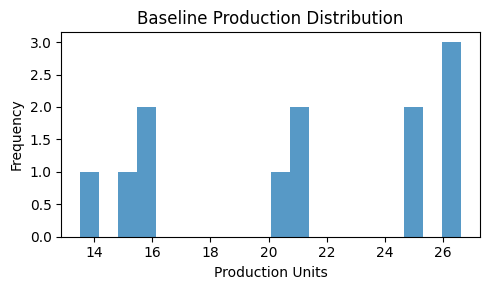

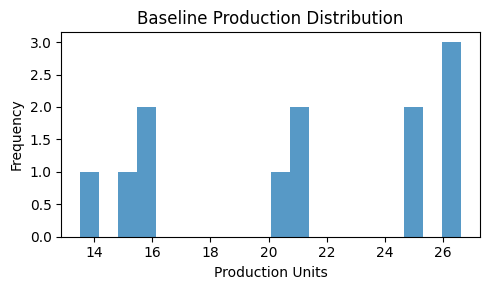

In [5]:
baseline_prod = baseline_tables.shift.groupby('sample_id')['production_units'].sum()
shock_prod = shock_tables.shift.groupby('sample_id')['production_units'].sum()
utils.plot_distribution(baseline_prod, title='Baseline Production Distribution', xlabel='Production Units')

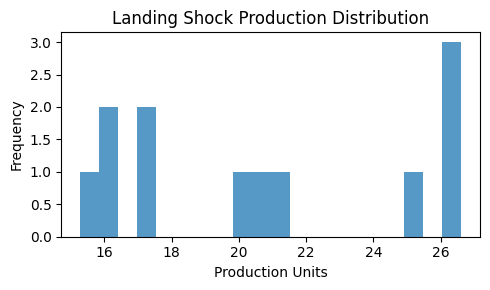

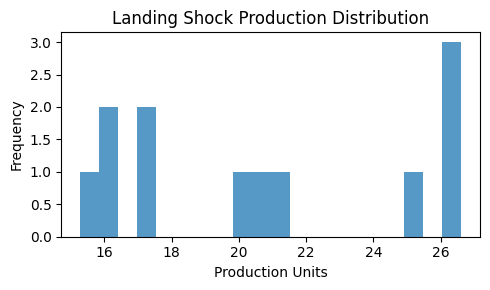

In [6]:
utils.plot_distribution(shock_prod, title='Landing Shock Production Distribution', xlabel='Production Units')